In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [2]:
# Загрузка данных:
DATA_TRAIN_PATH='train.csv'
DATA_TEST_PATH='test.csv'
RESULT_PATH='./predictions.csv'
data=pd.read_csv(DATA_TRAIN_PATH)
data_test=pd.read_csv(DATA_TEST_PATH)

In [3]:
df=data.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [4]:
#LifeSquare, Healthcare_1 - имеют пропуски
#Ecology_2, Ecology_3, Shops_2 - нечисловые признаки
#ID, Districtid - имеют тип int64, но факту числовыми признаками не являются

In [5]:
df.DistrictId=df.DistrictId.astype('str')
df.Id=df.Id.astype('str')

In [6]:
df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


Целевая переменная

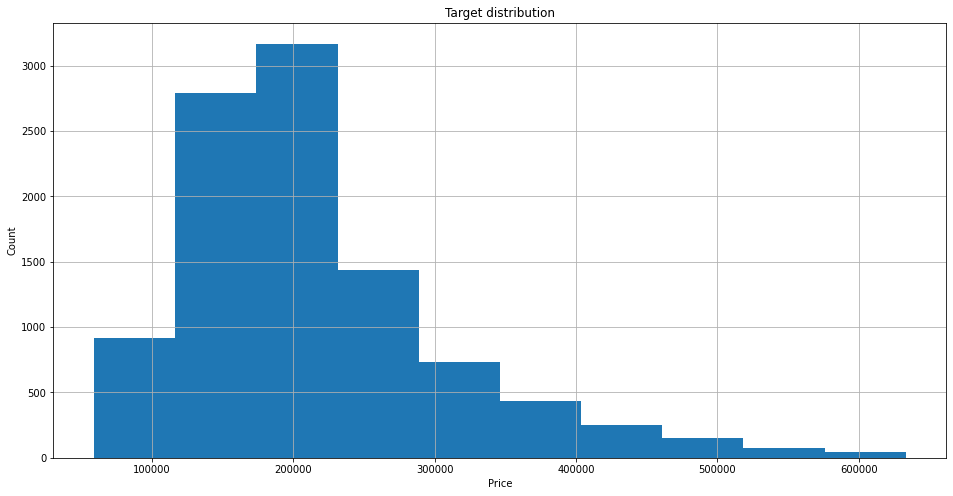

In [7]:
plt.figure(figsize = (16, 8))

df['Price'].hist(bins=10)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

Количесвенные переменные

In [8]:
df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [9]:
df.loc[(df.Rooms > 6) | (df.Rooms < 1)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
377,5927,57,10.0,59.056975,36.223072,10.0,22,22.0,2002,0.090799,B,B,74,19083,2,NaN,5,15,B,317265.323792
1397,12638,27,0.0,138.427694,136.215499,0.0,4,3.0,2016,0.075424,B,B,11,3097,0,NaN,0,0,B,268394.744389
1454,8491,1,19.0,42.006046,21.779288,7.0,17,17.0,2014,0.007122,B,B,1,264,0,NaN,0,1,B,78364.616704
1981,7917,27,0.0,212.932361,211.231125,0.0,2,3.0,2008,0.211401,B,B,9,1892,0,NaN,0,1,B,302211.260887
2269,7317,27,0.0,41.790881,NaN,0.0,13,0.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,98129.976788
3911,770,28,0.0,49.483501,NaN,0.0,16,0.0,2015,0.118537,B,B,30,6207,1,1183.0,1,0,B,217009.338463
4366,456,6,0.0,81.491446,NaN,0.0,4,0.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,212864.799112
4853,3224,27,0.0,2.377248,0.873147,0.0,1,0.0,1977,0.017647,B,B,2,469,0,NaN,0,0,B,126596.941798
6149,3159,88,0.0,38.697117,19.345131,9.0,9,16.0,1982,0.127376,B,B,43,8429,3,NaN,3,9,B,158998.110646
8834,9443,27,0.0,87.762616,85.125471,0.0,5,15.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,219281.918007


In [10]:
df.groupby('Rooms').mean()[['Square']]

,Square
Rooms,
0.0,81.620358
1.0,41.323277
2.0,56.788214
3.0,76.903234
4.0,98.377544
5.0,122.614941
6.0,59.414334
10.0,59.964120
19.0,42.006046


In [11]:
#Вывод: 0 и больше 5 комнат имеют аномальные значения.
#Переназначим их соответственно их площади.(Диапазон однушек 56-41=15 41+15/2=48 т.е. до 48 однушки. Подобным образом найдем оставшиеся диапазоны)

In [12]:
df.loc[(((df.Rooms<1) | (df.Rooms>5))&(df.Square<48)), 'Rooms']=1
df.loc[(((df.Rooms<1) | (df.Rooms>5))&(df.Square<61)&(df.Square>=48)), 'Rooms']=2
df.loc[(((df.Rooms<1) | (df.Rooms>5))&(df.Square<87)&(df.Square>=61)), 'Rooms']=3
df.loc[(((df.Rooms<1) | (df.Rooms>5))&(df.Square<110)&(df.Square>=87)), 'Rooms']=4
df.loc[(((df.Rooms<1) | (df.Rooms>5))&(df.Square>=110)), 'Rooms']=5

In [13]:
df.groupby('Rooms').mean()[['Square']]

,Square
Rooms,
1.0,41.312379
2.0,56.788644
3.0,76.905286
4.0,98.307246
5.0,127.921450


In [14]:
df.sort_values(by='Square', axis=0, ascending=True).head(20)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
6392,14786,1,1.0,1.136859,4.525736,1.0,3,1.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,181434.825589
8283,15744,34,1.0,1.988943,2.642219,1.0,21,4.0,1977,0.069753,B,B,53,13670,4,NaN,1,11,B,458378.777006
4853,3224,27,1.0,2.377248,0.873147,0.0,1,0.0,1977,0.017647,B,B,2,469,0,NaN,0,0,B,126596.941798
1608,10202,6,1.0,2.596351,4.604943,1.0,3,25.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,137597.601458
9294,6782,45,1.0,2.954309,5.257278,1.0,3,1.0,1977,0.195781,B,B,23,5212,6,NaN,3,2,B,438005.182323
3280,10527,27,1.0,4.380726,40.805837,1.0,10,17.0,2013,0.211401,B,B,9,1892,0,NaN,0,1,B,97560.720383
4900,4504,27,3.0,4.390331,5.610772,1.0,8,19.0,2016,0.211401,B,B,9,1892,0,NaN,0,1,B,161379.067034
9613,7657,38,1.0,4.502784,4.618547,1.0,28,1.0,1977,0.060753,B,B,15,2787,2,520.0,0,7,B,483283.488083
1316,11526,27,1.0,4.633498,1.969969,1.0,18,1.0,1977,0.011654,B,B,4,915,0,NaN,0,0,B,107604.269441
8030,13265,1,3.0,4.823679,79.767964,0.0,6,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,237716.681261


In [15]:
#Площадь < 13 выглядит явно аномальной. Переназначим их соответственно кол-ву комнат и ср. площади, аналогично колонке Rooms.

In [16]:
df.loc[((df.Square<13)&(df.Rooms==1)), 'Square']=41
df.loc[((df.Square<13)&(df.Rooms==2)), 'Square']=57
df.loc[((df.Square<13)&(df.Rooms==3)), 'Square']=77
df.loc[((df.Square<13)&(df.Rooms==4)), 'Square']=98
df.loc[((df.Square<13)&(df.Rooms==5)), 'Square']=128

In [17]:
#LifeSquare не может быть больше (Square-KitchenSquare), NAN тоже необходимо исключить

In [18]:
df.loc[(df.Square - df.KitchenSquare < df.LifeSquare), 'LifeSquare'] 

3        52.731512
28       43.967759
44      106.340403
48       46.807989
52       65.224603
           ...    
9897     38.010046
9902     44.267551
9910    201.627361
9918     99.788387
9974     32.639166
Name: LifeSquare, Length: 838, dtype: float64

In [19]:
#Для вычисления LifeSquare используем упрощенную формулу Square-KitchenSquare т.к. LifeSquare не может быть больше.
# Исходя из того что любое положительное значение KitchenSquare возможно. При 0 - квартира студия.

In [20]:
df.loc[df['LifeSquare'].isnull(), 'LifeSquare'] = df['Square'] - df['KitchenSquare'] 

In [21]:
df.loc[(df.Square - df.KitchenSquare < df.LifeSquare), 'LifeSquare'] = df['Square'] - df['KitchenSquare'] 

In [22]:
df.loc[(df.Square - df.KitchenSquare < df.LifeSquare), 'LifeSquare']

Series([], Name: LifeSquare, dtype: float64)

In [23]:
df.loc[df['LifeSquare'].isnull(), 'LifeSquare']

Series([], Name: LifeSquare, dtype: float64)

In [24]:
df.loc[(df.KitchenSquare < 0), 'LifeSquare']

Series([], Name: LifeSquare, dtype: float64)

In [25]:
#Floor&HouseFloor

In [26]:
df['Floor'].value_counts().sort_index(ascending=True)

1     235
2     588
3     872
4     949
5     876
6     802
7     759
8     643
9     604
10    553
11    457
12    438
13    398
14    362
15    287
16    290
17    256
18    185
19    121
20     68
21     59
22     54
23     25
24     53
25     34
26     18
27      5
28      3
31      1
32      2
33      1
37      1
42      1
Name: Floor, dtype: int64

In [27]:
df['HouseFloor'].value_counts().sort_index(ascending=True)

0.0       269
1.0       497
2.0        48
3.0       127
4.0       134
5.0      1031
6.0        58
7.0        59
8.0       141
9.0      1389
10.0      135
11.0       28
12.0     1074
13.0       27
14.0      625
15.0      123
16.0      576
17.0     2331
18.0       89
19.0      108
20.0      105
21.0       33
22.0      343
23.0       40
24.0      176
25.0      374
26.0        1
27.0        6
28.0        3
29.0        1
30.0       21
31.0        1
32.0        4
36.0        1
37.0        4
38.0        1
39.0        2
40.0        7
44.0        1
45.0        1
47.0        1
48.0        2
99.0        2
117.0       1
Name: HouseFloor, dtype: int64

In [28]:
#Этаж квартиры не может быть больше этажности дома.В таких случаях HouseFloor=Floor

In [29]:
df.loc[(df.HouseFloor < df.Floor), ['HouseFloor','Floor']]

,HouseFloor,Floor
7,0.0,14
14,4.0,5
16,5.0,6
21,1.0,15
23,0.0,2
...,...,...
9984,9.0,11
9985,1.0,10
9989,24.0,26
9991,17.0,18


In [30]:
df.loc[(df.HouseFloor < df.Floor), 'HouseFloor'] = df['Floor']

In [31]:
df.loc[[7, 14, 16, 21, 23], ['HouseFloor','Floor']]

,HouseFloor,Floor
7,14.0,14
14,5.0,5
16,6.0,6
21,15.0,15
23,2.0,2


In [32]:
df.sort_values(by='HouseYear', axis=0, ascending=False).head(5)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1497,10814,109,1.0,37.265070,20.239714,9.0,9,12.0,20052011,0.136330,B,B,30,6141,10,262.0,3,6,B,254084.534396
4189,11607,147,2.0,44.791836,28.360393,5.0,4,9.0,4968,0.319809,B,B,25,4756,16,2857.0,5,8,B,243028.603096
5701,8892,62,1.0,49.298503,40.298503,9.0,9,12.0,2020,0.072158,B,B,2,629,1,NaN,0,0,A,151779.182589
2493,3445,53,1.0,35.672788,21.391266,8.0,4,24.0,2020,0.049637,B,B,34,7759,0,229.0,1,3,B,170847.416766
1499,6731,120,2.0,85.087643,75.087643,10.0,7,10.0,2020,0.341072,B,B,27,5664,48,2300.0,3,11,B,536020.260344


In [33]:
df.loc[(df.HouseYear > 2022), 'HouseYear'] = df['HouseYear'] % 10000 #Если в числе больше 4 знаков

In [34]:
df.loc[(df.HouseYear > 2022), 'HouseYear'] = df['HouseYear'] % 1000 + 1000 #Если опечатка в первой цифре

In [35]:
df.loc[[1497, 4189, 8892], 'HouseYear']

1497    2011
4189    1968
8892    1998
Name: HouseYear, dtype: int64

In [36]:
# Healthcare_1 NAN к среднему

df.loc[df['Healthcare_1'].isnull(), 'Healthcare_1'] = df['Healthcare_1'].median()

Категориальные переменные

In [37]:
df.select_dtypes(include='object').columns.tolist()

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [38]:
df['DistrictId'].value_counts().head(20)

27    851
1     652
23    565
6     511
9     294
62    247
30    228
58    179
53    174
21    165
52    143
8     142
11    129
46    119
61    118
45    116
74    114
34    111
57    107
44    104
Name: DistrictId, dtype: int64

In [39]:
df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [40]:
df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [41]:
df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

In [42]:
# A = 0, B = 1

In [43]:
df['Ecology_2'] = df['Ecology_2'].replace({'A':0, 'B':1})
df['Ecology_3'] = df['Ecology_3'].replace({'A':0, 'B':1})
df['Shops_2'] = df['Shops_2'].replace({'A':0, 'B':1})

Отбор признаков

In [44]:
df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price']

In [45]:
feature_names = ['DistrictId','Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2']

target_name = 'Price'

In [46]:
def processing_data(data):
  df=data.copy()
  #Переводим в DistrictId Id в категориальные признаки

  df.DistrictId=df.DistrictId.astype('str')
  df.Id=df.Id.astype('str')

  #Обработка столбца Rooms

  df.loc[(((df.Rooms<1) | (df.Rooms>5))&(df.Square<48)), 'Rooms']=1
  df.loc[(((df.Rooms<1) | (df.Rooms>5))&(df.Square<61)&(df.Square>=48)), 'Rooms']=2
  df.loc[(((df.Rooms<1) | (df.Rooms>5))&(df.Square<87)&(df.Square>=61)), 'Rooms']=3
  df.loc[(((df.Rooms<1) | (df.Rooms>5))&(df.Square<110)&(df.Square>=87)), 'Rooms']=4
  df.loc[(((df.Rooms<1) | (df.Rooms>5))&(df.Square>=110)), 'Rooms']=5

  #Оброботка столбца Square

  df.loc[((df.Square<13)&(df.Rooms==1)), 'Square']=41
  df.loc[((df.Square<13)&(df.Rooms==2)), 'Square']=57
  df.loc[((df.Square<13)&(df.Rooms==3)), 'Square']=77
  df.loc[((df.Square<13)&(df.Rooms==4)), 'Square']=98
  df.loc[((df.Square<13)&(df.Rooms==5)), 'Square']=128

  #Оброботка столбца LifeSquare

  df.loc[df['LifeSquare'].isnull(), 'LifeSquare'] = df['Square'] - df['KitchenSquare'] 
  df.loc[(df.Square - df.KitchenSquare < df.LifeSquare), 'LifeSquare'] = df['Square'] - df['KitchenSquare']

  #Оброботка столбца Floor

  df.loc[(df.HouseFloor < df.Floor), 'HouseFloor'] = df['Floor'] 

  #Оброботка столбца HouseYear

  df.loc[(df.HouseYear > 2022), 'HouseYear'] = df['HouseYear'] % 10000
  df.loc[(df.HouseYear > 2022), 'HouseYear'] = df['HouseYear'] % 1000 + 1000

  #Оброботка столбца Healthcare_1 

  df.loc[df['Healthcare_1'].isnull(), 'Healthcare_1'] = df['Healthcare_1'].median()

  #Оброботка столбцов Ecology_2, Ecology_3, Shops_2

  df['Ecology_2'] = df['Ecology_2'].replace({'A':0, 'B':1})
  df['Ecology_3'] = df['Ecology_3'].replace({'A':0, 'B':1})
  df['Shops_2'] = df['Shops_2'].replace({'A':0, 'B':1})

  return df


In [47]:
df.shape

(10000, 20)

Разделение на train & test

In [48]:
X = df[feature_names]
y = df[target_name]

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

Построение модели

In [50]:
rf_model = RandomForestRegressor(random_state=21)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=21)

Отложенная выборка

In [51]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    """Оценка качества модели и график"""
    
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))

    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)   
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)   
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show

Train R2:	0.962
Test R2:	0.726


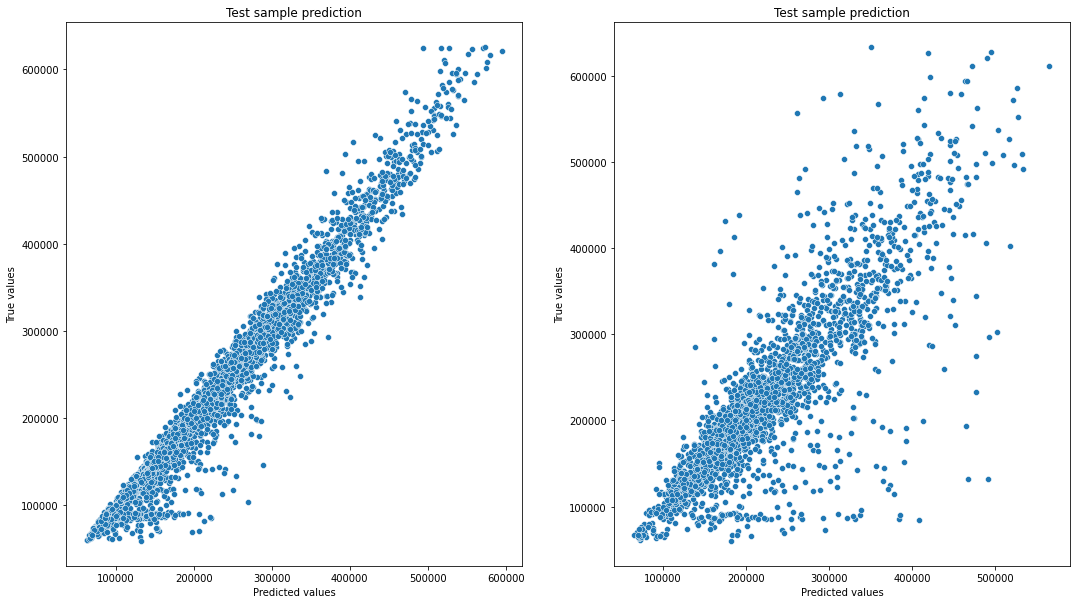

In [52]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

In [53]:
from sklearn.utils import shuffle
cv_score = cross_val_score(rf_model, X, y, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.72758718, 0.72282452, 0.74000027])

In [54]:
cv_score.mean()

0.7301373222205031

Важность признаков

In [55]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_),
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
2,Square,0.388503
11,Social_1,0.115270
1,Rooms,0.079299
12,Social_2,0.073194
13,Social_3,0.050829
0,DistrictId,0.048197
8,Ecology_1,0.038912
3,LifeSquare,0.038313
7,HouseYear,0.034889
6,HouseFloor,0.029868


Подготовим  данные test.csv для предсказания

In [56]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

In [57]:
data_test.shape

(5000, 19)

In [58]:
# обработаем новые данные тем же спопосбом, что и данные на которых обучали модель

processed_new_data = processing_data(data_test)

In [59]:
X_t_test = processed_new_data.drop(['Id'], axis=1)

In [60]:
# предскажем цены квартир для новых наблюдений
y_t_test_preds = rf_model.predict(X_t_test)

In [61]:
predictions = pd.DataFrame({'Id': processed_new_data.index,'Price': y_t_test_preds})

In [62]:
predictions.head()

,Id,Price
0,0,165545.615729
1,1,198387.285642
2,2,218012.996132
3,3,362682.399561
4,4,146001.074673


In [63]:
# сохраним предсказания в csv файл
predictions.to_csv('predictions.csv', sep=',', index=False, encoding='utf-8')


In [ ]:
# Выводы: Судя по сделанным расчетам, ключевым фактором в ценообразовании является площадь квартиры. Также значительную роль играют объекты соц структуры и количество комнат.
# В меньшей степени при оценке квартир учитываются такие факторы как Район, Жилая площадь, Экология и год постройки квартиры. А Этажность дома, Этаж квартиры, Площадь кухни, 
# наличие объектов здравоохранения, магазинов поблизости влияют на цену меньше всего.
#Также можно заключить, что более логичное ценообразование, а значит и более предсказуемое, в нижнем и среднем ценовом сегменте. А вот на цены дорогих квартир влияют факторы,
# не отраженные в представленных данных. Можно предположить, что их ценность связана с известностью их прошлых жильцов или другими подобными факторами.
#В целом можно подытожить, методы и инструменты , которые предоставляет машинное обучение являются эффективными и позволяют совершать довольно точные прогнозы.
